In [ ]:
!pip uninstall umap
!pip install umap-learn
!pip install python-igraph
!pip install cifar10_web

In [ ]:
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.autograd import Variable
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import torch
from cifar10_web import cifar10
import keras

In [ ]:
from keras.datasets import mnist
#(train_X, train_X), (train_X, train_X) = mnist.load_data()

In [ ]:
from keras.datasets import cifar10
(train_X, train_y), (test_X, test_y) = keras.datasets.cifar10.load_data()

In [ ]:
train_X.shape

(50000, 32, 32, 3)

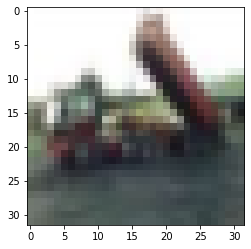

In [ ]:
plt.imshow(train_X[2])

In [ ]:
m1 = np.reshape(train_X, (-1,32*32*3))

In [ ]:
m2 = np.reshape(m1, (-1,32,32,3))

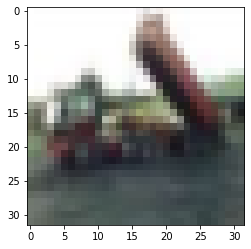

In [ ]:
plt.imshow(m2[2])

In [ ]:
train_X = np.reshape(train_X, (-1,3*32*32))
test_X = np.reshape(test_X, (-1,3*32*32))
X = np.concatenate((train_X,test_X),axis=0)
X = X/255
Y = np.concatenate((train_y,test_y),axis=0)
df_X=pd.DataFrame(X)
df_Y=pd.DataFrame(Y)
df_Y.columns=["Y"]
df_XY = pd.concat([df_X, df_Y],axis=1)

In [ ]:
df_XY

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047,3048,3049,3050,3051,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071,Y
0,0.231373,0.243137,0.247059,0.168627,0.180392,0.176471,0.196078,0.188235,0.168627,0.266667,0.211765,0.164706,0.384314,0.286275,0.203922,0.466667,0.356863,0.247059,0.545098,0.419608,0.294118,0.568627,0.431373,0.313725,0.584314,0.458824,0.349020,0.584314,0.470588,0.364706,0.513725,0.403922,0.301961,0.490196,0.388235,0.298039,0.556863,0.450980,0.356863,0.564706,...,0.580392,0.403922,0.301961,0.631373,0.411765,0.270588,0.564706,0.372549,0.215686,0.439216,0.352941,0.231373,0.466667,0.356863,0.227451,0.509804,0.376471,0.254902,0.470588,0.341176,0.231373,0.360784,0.262745,0.180392,0.403922,0.305882,0.223529,0.666667,0.549020,0.407843,0.847059,0.721569,0.549020,0.592157,0.462745,0.329412,0.482353,0.360784,0.282353,6
1,0.603922,0.694118,0.733333,0.494118,0.537255,0.533333,0.411765,0.407843,0.372549,0.400000,0.396078,0.388235,0.490196,0.513725,0.545098,0.607843,0.650980,0.705882,0.674510,0.745098,0.823529,0.705882,0.780392,0.839216,0.556863,0.611765,0.611765,0.435294,0.470588,0.431373,0.415686,0.419608,0.384314,0.427451,0.407843,0.400000,0.482353,0.474510,0.458824,0.498039,...,0.019608,0.023529,0.043137,0.023529,0.023529,0.043137,0.039216,0.035294,0.047059,0.098039,0.086275,0.086275,0.200000,0.176471,0.164706,0.266667,0.250980,0.262745,0.352941,0.352941,0.396078,0.454902,0.443137,0.478431,0.525490,0.498039,0.521569,0.549020,0.509804,0.533333,0.560784,0.521569,0.545098,0.560784,0.525490,0.556863,0.560784,0.521569,0.564706,9
2,1.000000,1.000000,1.000000,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,...,0.298039,0.352941,0.352941,0.282353,0.337255,0.337255,0.250980,0.305882,0.305882,0.250980,0.305882,0.305882,0.270588,0.325490,0.325490,0.258824,0.313725,0.313725,0.215686,0.270588,0.270588,0.203922,0.258824,0.258824,0.227451,0.282353,0.282353,0.266667,0.313725,0.309804,0.305882,0.333333,0.325490,0.309804,0.333333,0.325490,0.313725,0.337255,0.329412,9
3,0.109804,0.098039,0.039216,0.145098,0.133333,0.074510,0.149020,0.137255,0.078431,0.164706,0.145098,0.090196,0.172549,0.152941,0.098039,0.156863,0.145098,0.086275,0.156863,0.149020,0.090196,0.094118,0.090196,0.035294,0.125490,0.098039,0.058824,0.168627,0.105882,0.074510,0.117647,0.078431,0.039216,0.125490,0.117647,0.066667,0.160784,0.145098,0.090196,0.203922,...,0.478431,0.388235,0.262745,0.419608,0.333333,0.211765,0.439216,0.376471,0.258824,0.360784,0.317647,0.207843,0.313725,0.243137,0.152941,0.376471,0.305882,0.231373,0.301961,0.262745,0.164706,0.333333,0.298039,0.172549,0.329412,0.294118,0.188235,0.262745,0.223529,0.149020,0.211765,0.184314,0.109804,0.247059,0.219608,0.145098,0.282353,0.254902,0.180392,4
4,0.666667,0.705882,0.776471,0.658824,0.698039,0.768627,0.694118,0.725490,0.796078,0.717647,0.756863,0.827451,0.709804,0.768627,0.854902,0.694118,0.764706,0.862745,0.709804,0.764706,0.874510,0.721569,0.752941,0.874510,0.741176,0.745098,0.874510,0.741176,0.741176,0.870588,0.737255,0.756863,0.878431,0.717647,0.760784,0.874510,0.713725,0.760784,0.874510,0.721569,...,0.364706,0.384314,0.400000,0.352941,0.372549,0.388235,0.345098,0.364706,0.380392,0.325490,0.349020,0.360784,0.301961,0.341176,0.345098,0.294118,0.329412,0.333333,0.278431,0.317647,0.321569,0.290196,0.313725,0.325490,0.282353,0.298039,0.309804,0.278431,0.294118,0.305882,0.294118,0.309804,0.321569,0.278431,0.294118,0.305882,0.286275,0.301961,0.313725,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
#######################
#df_map=pd.DataFrame({'cancer_type':df_XY["cancer_type"],'batch_no':df_XY["batch_no"]})
#df_map=df_map.drop_duplicates()
######## vae implementation
# set random seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# setup device cuda vs. cpu
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

# set batch size
#batch_size = 256

import pandas as pd
from torch.utils.data import Dataset
import torch


class MyDataset(Dataset):
    def __init__(self,df,y_label ,mode = 'train'):
          self.mode = mode
          #le = LabelEncoder()        
          if self.mode == 'train':
              #df = df.dropna()
              self.oup = df.loc[:, y_label].values
              self.inp  = df.drop(columns=y_label)
              
              self.x_features=self.inp.columns.tolist()
              # self.x_mean=np.mean(self.inp)
              # self.x_std=np.std(self.inp)
              # self.inp = (self.inp - self.x_mean) / self.x_std
              self.inp = self.inp.values      # df.values == Return a Numpy representation of the DataFrame
              self.inp = np.reshape(self.inp, (-1,3,32,32)) # for image
          else:
              self.inp = df.values
              self.inp = np.reshape(self.inp, (-1,3,32,32)) # for image
              self.x_features = self.inp.columns.tolist()
    def __len__(self):
        return (self.inp).shape[0]
    def __dim__(self):
        return (self.inp).shape[1]
    def __getitem__(self, idx):
        if self.mode == 'train':
            inpt  = torch.Tensor(self.inp[idx])
            oupt  = torch.Tensor(self.oup[idx])
            return (inpt,oupt)
        else:
            inpt = torch.Tensor(self.inp[idx])
            return inpt



from sklearn.model_selection import train_test_split
df_XY = df_XY.sample(frac = 1)

df_XY_train, df_XY_test = train_test_split(df_XY, test_size=0.2)

data_train = MyDataset(df=df_XY_train,y_label=["Y"])
data_test = MyDataset(df=df_XY_test,y_label=["Y"])

BATCH_SIZE=256
trainloader = torch.utils.data.DataLoader(dataset = data_train,
                                           batch_size = BATCH_SIZE,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(dataset = data_test,
                                          batch_size = BATCH_SIZE,
                                         shuffle=True)

input_size=df_XY.shape[1]-1


In [ ]:
capacity = 32
c=capacity
latent_dims = 16
dropout_rate=0.10

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 8 x 8
        self.fc_mu = nn.Linear(in_features=c*2*8*8, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*8*8, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*8*8)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 8, 8) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class VAE_cnn(nn.Module):
    def __init__(self):
        super(VAE_cnn, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.classifier = nn.Sequential (
            nn.Linear(latent_dims, 10),
            #nn.BatchNorm1d(10),
            nn.Dropout(p = 0.80)
            #nn.Softmax()
        )

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        y_hat=self.classifier(latent)
        return x_recon,y_hat, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    

In [ ]:
# model
model = VAE_cnn().cuda()

# Training the model
train_tracker=[]
test_tracker=[]

test_BCE_tracker=[]
test_KLD_tracker=[]
test_CEP_tracker=[]

codes = dict(μ=list(), logσ2=list(), y=list(), x=list())

iteration_no = 0

In [ ]:
# Setting the optimiser
learning_rate = 5e-4

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=2e-5)

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x_hat, x,y_hat,y, mu, logvar):
    
    # reconstruction loss (pushing the points apart)
    #BCE = nn.functional.binary_cross_entropy(x_hat, x.view(-1, input_size), reduction='sum')
    BCE = F.binary_cross_entropy(x_hat.view(-1, 3*32*32), x.view(-1, 3*32*32), reduction='sum')
    #mse_loss = nn.MSELoss()
    #BCE = mse_loss(np.reshape(x_hat.detach().cpu().numpy(), (-1,3*32*32)), x.view(-1, 3*32*32))
    crs_entrpy = nn.CrossEntropyLoss()
    CEP = crs_entrpy(y_hat.cuda(),y.cuda())
    # KL divergence loss (the relative entropy between two distributions a multivariate gaussian and a normal)
    # (enforce a radius of 1 in each direction + pushing the means towards zero)
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    KLD = torch.abs(KLD)

    BCE = BCE *1
    KLD = KLD * 1
    CEP = CEP * 1000
    
    Tot_Loss = BCE + KLD + CEP
    return BCE, KLD, CEP, Tot_Loss  # we can use a beta parameter here (BCE + beta * KLD)

# performs one epoch of training and returns the training loss for this epoch
def train():
  model.train()
  train_loss = 0
  for x, y in trainloader:
    x = x.cuda()
    y = y.cuda()
    y = torch.tensor(torch.reshape(y, (-1,)), dtype=torch.long)
    #print(x.shape)
    #print(y.shape)
    # ===================forward=====================
    optimizer.zero_grad()
    x_hat, y_hat, mu, logvar = model(x)
    #print(x_hat.shape)
    BCE_loss, KLD_loss, CEP_loss, total_loss = loss_function(x_hat, x,y_hat,y, mu, logvar)
    # ===================backward====================
    #optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    train_loss = train_loss + total_loss.item()
  return train_loss

# evaluates the model on the test set
def test():
  means, logvars, labels, images = list(), list(), list(), list()
  test_BCE_loss=0
  test_KLD_loss=0
  test_CEP_loss=0
  test_total_loss = 0
  with torch.no_grad():
    model.eval()
    for x, y in testloader:
      x = x.cuda()
      y = y.cuda()
      y=y.cuda()
      y=torch.tensor(torch.reshape(y, (-1,)), dtype=torch.long)
      # forward
      x_hat,y_hat, mu, logvar = model(x)
      BCE_loss, KLD_loss, CEP_loss, total_loss = loss_function(x_hat, x, y_hat,y, mu, logvar)
      test_total_loss = test_total_loss + total_loss.item()
      test_BCE_loss = test_BCE_loss + BCE_loss.item()
      test_KLD_loss = test_KLD_loss + KLD_loss.item()
      test_CEP_loss = test_CEP_loss + CEP_loss.item()
      # log
      means.append(mu.detach())
      logvars.append(logvar.detach())
      labels.append(y.detach())
      images.append(x.detach())
  return test_BCE_loss, test_KLD_loss, test_CEP_loss, test_total_loss, means, logvars, labels, images

In [ ]:
epochs = 1000
loss_scale_show=1
for epoch in range(1, epochs+1):
    iteration_no = iteration_no+1
    # train for one epocha
    train_total_loss = train()

    # print the train loss for the epoch
    #print(f'====> Epoch: {epoch} Average train loss: {train_loss*loss_scale_show / len(trainloader.dataset):.15f}')
    
    # evaluate this epoch over the test set
    test_BCE_loss, test_KLD_loss, test_CEP_loss, test_total_loss, means, logvars, labels, images = test()
    
    # log for analysis
    #codes['μ'].append(torch.cat(means))
    #codes['logσ2'].append(torch.cat(logvars))
    
    #miu_last=torch.cat(means)
    #var_last=torch.cat(logvars)
    #y_last=torch.cat(labels)
    #x_last=torch.cat(images)
    miu_last=torch.cat(means)
    var_last=torch.cat(logvars)
    y_last=torch.cat(labels)
    x_last=torch.cat(images)

    train_total_loss_scaled = train_total_loss*loss_scale_show/ len(trainloader.dataset)
    test_total_loss_scaled = test_total_loss*loss_scale_show/ len(testloader.dataset)
    test_BCE_loss_scaled = test_BCE_loss*loss_scale_show/ len(testloader.dataset)
    test_KLD_loss_scaled = test_KLD_loss*loss_scale_show/ len(testloader.dataset)
    test_CEP_loss_scaled = test_CEP_loss*loss_scale_show/ len(testloader.dataset)
    

    train_tracker.append(train_total_loss_scaled)
    test_tracker.append(test_total_loss_scaled)
    test_BCE_tracker.append(test_BCE_loss_scaled)
    test_KLD_tracker.append(test_KLD_loss_scaled)
    test_CEP_tracker.append(test_CEP_loss_scaled)


    # print the test loss for the epoch
    print(f'====> Epoch: {iteration_no} total_train_loss: {train_total_loss_scaled:.6f} Total_test_loss: {test_total_loss_scaled:.6f} Total_BCE_test_loss: {test_BCE_loss_scaled:.6f} Total_KLD_test_loss: {test_KLD_loss_scaled:.6f} Total_CEP_test_loss: {test_CEP_loss_scaled:.6f}')
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


====> Epoch: 206 total_train_loss: 1849.525417 Total_test_loss: 1844.185974 Total_BCE_test_loss: 1810.338966 Total_KLD_test_loss: 25.430030 Total_CEP_test_loss: 8.416973
====> Epoch: 207 total_train_loss: 1849.485637 Total_test_loss: 1843.963607 Total_BCE_test_loss: 1810.211690 Total_KLD_test_loss: 25.337924 Total_CEP_test_loss: 8.413995
====> Epoch: 208 total_train_loss: 1849.559132 Total_test_loss: 1844.206617 Total_BCE_test_loss: 1810.435073 Total_KLD_test_loss: 25.344020 Total_CEP_test_loss: 8.427534
====> Epoch: 209 total_train_loss: 1849.537008 Total_test_loss: 1844.313979 Total_BCE_test_loss: 1810.234664 Total_KLD_test_loss: 25.654083 Total_CEP_test_loss: 8.425231
====> Epoch: 210 total_train_loss: 1849.453330 Total_test_loss: 1844.393622 Total_BCE_test_loss: 1810.399789 Total_KLD_test_loss: 25.574939 Total_CEP_test_loss: 8.418894
====> Epoch: 211 total_train_loss: 1849.553570 Total_test_loss: 1844.048122 Total_BCE_test_loss: 1810.344763 Total_KLD_test_loss: 25.279478 Total_CEP_

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/coh_pm/data/vae-model-cifar10_cnn.pt')
# loading a saved module

In [ ]:
model = VAE_cnn().cuda()
model.load_state_dict(torch.load('/content/drive/MyDrive/coh_pm/data/vae-model-cifar10_cnn.pt'))

<All keys matched successfully>

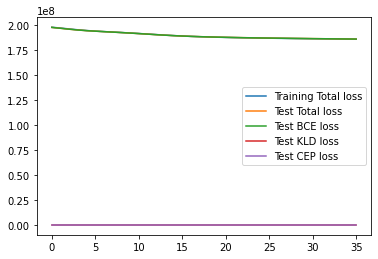

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
init_index=10
plt.plot(train_tracker[init_index:], label='Training Total loss')
plt.plot(test_tracker[init_index:], label='Test Total loss')
plt.plot(test_BCE_tracker[init_index:], label='Test BCE loss')
plt.plot(test_KLD_tracker[init_index:], label='Test KLD loss')
plt.plot(test_CEP_tracker[init_index:], label='Test CEP loss')
plt.legend()

In [ ]:
loss_scale_show=1

test_tracker=[]
test_BCE_tracker=[]
test_KLD_tracker=[]
test_CEP_tracker=[]

for epoch in range(1):
    # the following line, will read test data from tes
    test_BCE_loss, test_KLD_loss, test_CEP_loss, test_total_loss, means, logvars, labels, images = test()
    

    miu_last=torch.cat(means)
    var_last=torch.cat(logvars)
    y_last=torch.cat(labels)
    x_last=torch.cat(images)

    
    test_total_loss_scaled = test_total_loss*loss_scale_show/ len(testloader.dataset)
    test_BCE_loss_scaled = test_BCE_loss*loss_scale_show/ len(testloader.dataset)
    test_KLD_loss_scaled = test_KLD_loss*loss_scale_show/ len(testloader.dataset)
    test_CEP_loss_scaled = test_CEP_loss*loss_scale_show/ len(testloader.dataset)
    

    test_tracker.append(test_total_loss_scaled)
    test_BCE_tracker.append(test_BCE_loss_scaled)
    test_KLD_tracker.append(test_KLD_loss_scaled)
    test_CEP_tracker.append(test_CEP_loss_scaled)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
N=2000
import random
index_rand=random.sample(range(1, miu_last.shape[0]), N)
import umap.umap_ as umap
from sklearn.manifold import TSNE
#X=x_last
X = miu_last
Y = y_last
X=X[index_rand,]
Y=Y[index_rand]
Y = list(map(int, Y))
E0 = TSNE(n_components=3).fit_transform(X.cpu())
reducer = umap.UMAP(random_state=42,n_components=20)
E = reducer.fit_transform(X.cpu())
#E=E[0]

KeyboardInterrupt: ignored

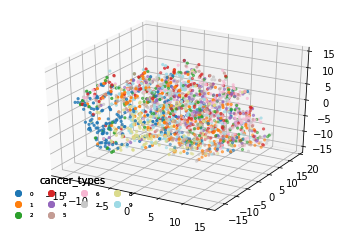

In [ ]:
############################
############################
ax = plt.axes(projection='3d')
#fig, ax = plt.subplots()
sc=ax.scatter(E0[:,0], E0[:,1],E0[:,2],
              c=Y,marker=".",
              cmap='tab20')
legend = ax.legend(*sc.legend_elements(),
                     title="cancer_types",
                     framealpha=0,
                     ncol=4,
                     loc=3,
                     fontsize='xx-small'
                     )
ax.add_artist(legend)
plt.show()
############################
#colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)


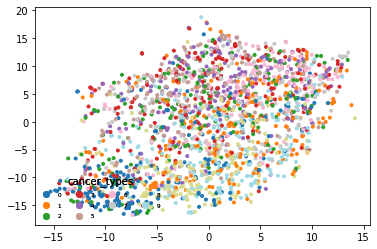

In [ ]:
############################
############################
ax = plt.axes()
#fig, ax = plt.subplots()
sc=ax.scatter(E0[:,0], E0[:,1],
              c=Y,marker=".",
              cmap='tab20')
legend = ax.legend(*sc.legend_elements(),
                     title="cancer_types",
                     framealpha=0,
                     ncol=4,
                     loc=3,
                     fontsize='xx-small'
                     )
ax.add_artist(legend)
plt.show()
############################
#colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

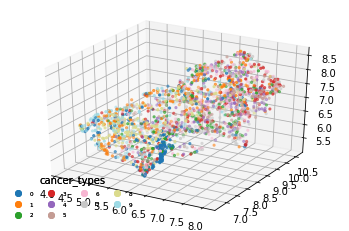

In [ ]:
############################
############################
ax = plt.axes(projection='3d')
#fig, ax = plt.subplots()
sc=ax.scatter(E[:,0], E[:,1],E[:,2],
              c=Y,marker=".",
              cmap='tab20')
legend = ax.legend(*sc.legend_elements(),
                     title="cancer_types",
                     framealpha=0,
                     ncol=4,
                     loc=3,
                     fontsize='xx-small'
                     )
ax.add_artist(legend)
plt.show()
############################
#colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)


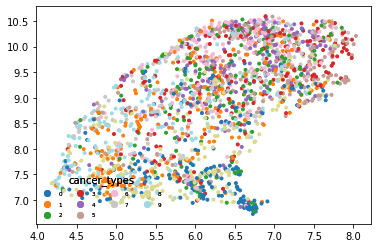

In [ ]:
############################
############################
ax = plt.axes()
#fig, ax = plt.subplots()
sc=ax.scatter(E[:,0], E[:,1],
              c=Y,marker=".",
              cmap='tab20')
legend = ax.legend(*sc.legend_elements(),
                     title="cancer_types",
                     framealpha=0,
                     ncol=4,
                     loc=3,
                     fontsize='xx-small'
                     )
ax.add_artist(legend)
plt.show()
############################
#colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)


In [ ]:
model.eval()

VAE_cnn(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=4096, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=4096, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=16, out_features=4096, bias=True)
    (conv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=10, bias=True)
    (1): Dropout(p=0.8, inplace=False)
  )
)

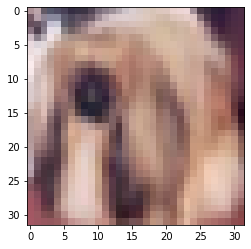

In [ ]:
model.eval()
number_class=5
image_number=3
plt.imshow((x_last[y_last==number_class][image_number].cpu().detach().numpy().reshape(32,32,3)*255).astype(int))

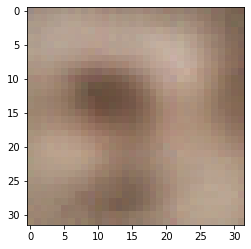

In [ ]:
model.eval()
with torch.no_grad():
  plt.imshow(model.decoder(miu_last[y_last==number_class][image_number:image_number+2]).cpu().detach().numpy().reshape(2,32,32,3)[0])

In [ ]:
#Latent Space Traversal

In [ ]:
def latent_traversal(points_mean,
                     points_std,
                     start_id,
                     end_id,
                     k_neighbor_ratio=0.1,
                     distance_eucludian=False,
                     plot_results_2d=True):
    n_samples=points_mean.shape[0]
    k=int(0.05*n_samples)
    
    def distance_kl(mean1,std1,mean2,std2):
        n=std1.shape[0]
        std1_mat=np.zeros((n,n))
        np.fill_diagonal(std1_mat, list(std1))
        std2_mat=np.zeros((n,n))
        np.fill_diagonal(std2_mat, list(std2))
        expression1 = np.log(np.linalg.det(std2_mat)/np.linalg.det(std1_mat))
        expression2 = np.trace(np.matmul(np.linalg.inv(std2_mat),std1_mat))
        expression3 = np.matmul(np.matmul((mean1-mean2).T,np.linalg.inv(std2_mat)),(mean1-mean2)) 
        distance = 1/2*(expression1-n+expression2+expression3)
        return(distance)
    
    
    dist_array = np.zeros([n_samples,n_samples])
    for i in range(n_samples):
        for j in range(n_samples):
            #print(i,j)
            if distance_eucludian:
                dist_array[i,j]=np.linalg.norm(points_mean[i,:]-points_mean[j,:])
            else:
                d1=distance_kl(points_mean[i,:],points_std[i,:],points_mean[j,:],points_std[j,:])
                d2=distance_kl(points_mean[j,:],points_std[j,:],points_mean[i,:],points_std[i,:])
                dist_array[i,j]=abs(d1+d2)/2
            
    
    adjucency_mat = np.zeros([n_samples,n_samples])
    for i in range(n_samples):
        nearest_ids = dist_array[i,:].argsort()[:k]
        nearest_ids = list(np.delete(nearest_ids,np.where(nearest_ids == i)))
        for j in nearest_ids:
            adjucency_mat[i,j] = dist_array[i,j]
    
        
    import igraph
    g=igraph.Graph.Weighted_Adjacency(adjucency_mat,mode='undirected')
    g.is_weighted()
    
    shrt_pth=g.get_shortest_paths(start_id, to=end_id,weights=g.es["weight"])
    shrt_pth

    if(plot_results_2d):
        import matplotlib.pyplot as plt
        size_dot=1
        plt.scatter(x=points_mean[:,0],y=points_mean[:,1],s=size_dot)
        plt.plot(points_mean[shrt_pth,0].tolist()[0],points_mean[shrt_pth,1].tolist()[0],'-r')
        plt.scatter(x=points_mean[shrt_pth[0],0],y=points_mean[shrt_pth[0],1],c='green',s=size_dot)
        plt.scatter(x=points_mean[shrt_pth[-1],0],y=points_mean[shrt_pth[-1],1],c='yellow',s=size_dot)
        plt.show()
        
    return(list(shrt_pth[0]))



def latent_traversal_interpolated(points_mean,
                                  points_std,
                                  steps,
                                  linespace_k=5):

    def getEquidistantPoints(p1, p2, parts):
        return (list(zip(*[np.linspace(p1[i], p2[i], parts+1) for i in range(len(p1))])))
    #############################
    ll=[]
    for i in list(range(len(steps)-1)):
        mm=getEquidistantPoints(points_mean[steps[i]], points_mean[steps[i+1]], linespace_k)
        ll=ll+mm
    for i in range(len(ll)):
        ll[i]=list(ll[i])
    points_mean_interpolated=np.array(ll) 
    #############################.        I think interpolating standard deviation is not meaningful. We calculated here but we are not going to use it. 
    ll=[]
    for i in list(range(len(steps)-1)):
        mm=getEquidistantPoints(points_std[steps[i]], points_std[steps[i+1]], linespace_k)
        ll=ll+mm
    for i in range(len(ll)):
        ll[i]=list(ll[i])
    points_std_interpolated=np.array(ll)
    
    return((points_mean_interpolated,points_std_interpolated))

In [ ]:
# Linear Traversal
start_id=10
end_id=50
model.eval()
with torch.no_grad():
  number_class=9
  number_of_images=20
  x0=miu_last[y_last==number_class][start_id]
  x1=miu_last[y_last==number_class][end_id]
  line_distance=x1-x0
  n=number_of_images
  delta=line_distance/n
  line = torch.empty(size=(number_of_images, 20))
  for i in range(number_of_images):
    line[i]=x0+i*delta
  line=line.cuda()
  line_decoded = np.fliplr(((model.decoder(line).cpu().detach().numpy().reshape(number_of_images,32,32,3)*255).astype(int)))

RuntimeError: ignored

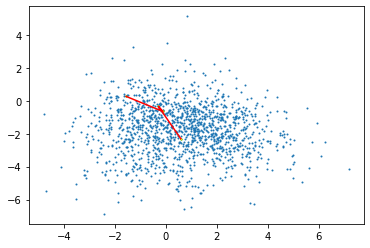

In [ ]:
# Graph Traversal
number_class=9
points_mean=miu_last[y_last==number_class].cpu().detach().numpy()
points_std=var_last[y_last==number_class].cpu().detach().numpy()
steps=latent_traversal(points_mean,
                 points_std,
                 start_id=10,
                 end_id=50,
                 k_neighbor_ratio=0.90,
                 distance_eucludian=True,
                 plot_results_2d=True)

In [ ]:
print(steps)
m,s=latent_traversal_interpolated(points_mean,
                                  points_std,
                                  steps,
                                  linespace_k=5)
line_m=torch.from_numpy(m).cuda().float()
line_s=torch.from_numpy(m).cuda().float()    # not using interpolated standard deviation as it may not be meaningful. Interpolating standard deviation, independent of mean I believe is not so correct.  
#line = reparameterise(line_m, line_s)
line_decoded2 = np.fliplr(((model.decoder(line_m).cpu().detach().numpy().reshape(-1,32,32,3)*255).astype(int)))

NameError: ignored

In [ ]:
number_class

9

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

a = line_decoded
#a = line_decoded2

a = np.array(a)

images = []

for array_ in a:
    file_path = "/content/drive/MyDrive/coh_pm/image_cifar10.png"

    img = plt.figure(figsize = (8,8))
    plt.imshow(array_, origin = 'lower')
    plt.colorbar(shrink = 0.5)

    plt.savefig(file_path) #Saves each figure as an image
    images.append(imageio.imread(file_path)) #Adds images to list
    plt.clf()

plt.close()
imageio.mimsave(file_path +"_"+str(number_class)+ ".gif", images, fps=1) #Creates gif out of list of images

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

1) UMAP/TSNE on entire data

2) Latent Space can be a predictor of Cancer Type

3) Try to regenerate the paper. 

4)  


latent dim =20



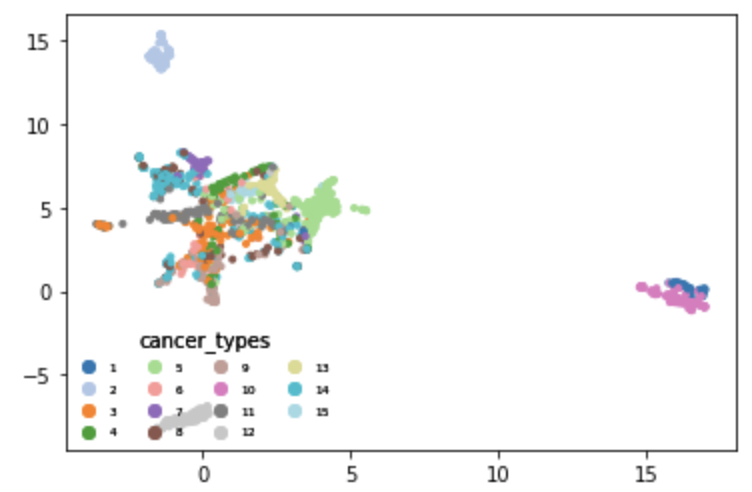